In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from torch.nn import Linear

In [2]:
# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden, num_output):
        super(Net, self).__init__()  
        # Linear layers
        self.l_1 = Linear(in_features= num_features,
                         out_features = num_hidden,
                         bias=True)
        
        self.l_2 = Linear(in_features= num_hidden,
                         out_features = num_hidden,
                         bias=True)
        # Out layer
        self.l_out = Linear(in_features=num_hidden,
                            out_features=num_output,
                            bias=False)
        
        # activation
        self.activation = nn.ReLU()
        #self.activation = nn.Sigmoid()
        
    def forward(self, x):
        x = self.l_1(x)
        x = self.activation(x)
        x = self.l_2(x)
        x = self.activation(x)
        x = self.l_out(x)
        return x


In [ ]:
x = torch.linspace(-1, 1, 100, requires_grad=True).reshape(-1, 1)
y = x**3 + x**2 -x
y_x = 3*x**2 + 2*x - 1

In [ ]:
net = Net(1, 100, 1)
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.MSELoss()
num_epochs = 1000
losses = []
for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    optimizer.zero_grad()
    output = net(x)

    # compute gradients given loss
    loss = criterion(output, y)
    loss.backward(retain_graph=True)
    optimizer.step()
    losses.append(loss/len(x))

In [ ]:
fig, axs = plt.subplots(3,1, figsize=(10,10))
axs[0].loglog(range(num_epochs), [l.detach() for l in losses])
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('MSE')
axs[1].plot(x.detach(), y.detach(), '-', color='black')
axs[1].plot(x.detach(), output.detach(), '.', color='red')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')

_y_x = torch.autograd.grad(net(x), x, torch.ones([x.shape[0], 1]))
axs[2].plot(x.detach(), y_x.detach(), '-', color='black')
axs[2].plot(x.detach(), _y_x[0].detach(), '.', color='red')
axs[2].set_xlabel('x')
axs[2].set_ylabel('dy/dx')

## 2D case

In [ ]:
def f(x1, x2):
    return x1.detach()**2 + torch.sin(x2.detach()*np.pi)
def dfdx1(x1, x2):
    return 2*x1
def dfdx2(x1, x2):
    return np.pi*torch.cos(x2*np.pi)

In [ ]:
x = torch.rand(200,requires_grad=True).reshape(-1, 2)
y = f(x[:,0], x[:,1])

In [ ]:
x1, x2 = np.meshgrid(np.linspace(1,0,50), np.linspace(1,0,50))
y1 = x1**2 + np.sin(x2*np.pi)
plt.contourf(x1, x2, y1)
plt.colorbar()
plt.scatter(x[:,0].detach(), x[:,1].detach(), c='red', marker='x')
plt.ylabel('x2')
plt.xlabel('x1')
plt.title('Samples from 2D function')

In [ ]:
net = Net(2, 1000, 1)
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.MSELoss()
num_epochs = 1000
losses = []
for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    optimizer.zero_grad()
    output = net(x)

    # compute gradients given loss
    loss = criterion(output, y.reshape(output.shape))
    loss.backward()
    optimizer.step()
    losses.append(loss/len(x[:,0]))
    

In [ ]:
fig, axs = plt.subplots(4,1, figsize=(5,10))
axs[0].semilogy(range(num_epochs), [l.detach() for l in losses])
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('MSE')

x1, x2 = np.meshgrid(np.linspace(1,0,50), np.linspace(1,0,50))
y1 = x1**2 + np.sin(x2*np.pi)

axs[1].contourf(x1, x2, y1)
axs[1].scatter(x[:,0].detach(), x[:,1].detach(), c=output.detach().T)
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')

_y_x = torch.autograd.grad(net(x), x, torch.ones([x.shape[0], 1]))
axs[2].plot(x[:,0].detach(), dfdx1(x[:,0], x[:, 1]).detach(), '.', color='black')
axs[2].plot(x.detach(), _y_x[0][:,0], '.', color='red')
axs[2].set_xlabel('x')
axs[2].set_ylabel('dy/dx1')

axs[3].plot(x[:,1].detach(), dfdx2(x[:,0], x[:, 1]).detach(), '.', color='black')
axs[3].plot(x.detach(), _y_x[0][:,1], '.', color='red')
axs[3].set_xlabel('x')
axs[3].set_ylabel('dy/dx2')
fig.tight_layout()

##  c) Use derivatives to improve

In [ ]:
y_x1 = dfdx1(x[:,0], x[:, 1]).detach()
y_x2 = dfdx2(x[:,0], x[:, 1]).detach()

In [ ]:
net = Net(2, 1000, 1)
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.MSELoss()
num_epochs = 1000
losses = []
for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    optimizer.zero_grad()
    output = net(x)

    # compute gradients given loss
    _loss = criterion(output, y.reshape(output.shape))
    _y_x = torch.autograd.grad(output, x, torch.ones([x.shape[0], 1]), create_graph=True)[0]
    _loss_derivative1 = criterion(_y_x[:,0], y_x1)
    _loss_derivative2 = criterion(_y_x[:,1], y_x2)
    loss = _loss + _loss_derivative1 + _loss_derivative2
    loss.backward()
    optimizer.step()
    losses.append(loss/len(x[:,0]))
    if epoch%100 == 0:
        print('Epoch: {}. Loss: {}'.format(epoch, losses[-1]))
    

In [ ]:
fig, axs = plt.subplots(4,1, figsize=(5,10))
axs[0].semilogy(range(num_epochs), [l.detach() for l in losses])
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('MSE')

x1, x2 = np.meshgrid(np.linspace(1,0,50), np.linspace(1,0,50))
y1 = x1**2 + np.sin(x2*np.pi)

axs[1].contourf(x1, x2, y1, 100)
axs[1].scatter(x[:,0].detach(), x[:,1].detach(), c=output.detach().T)
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')

_y_x = torch.autograd.grad(net(x), x, torch.ones([x.shape[0], 1]))
axs[2].plot(x[:,0].detach(), dfdx1(x[:,0], x[:, 1]).detach(), '.', color='black')
axs[2].plot(x.detach(), _y_x[0][:,0], '.', color='red')
axs[2].set_xlabel('x')
axs[2].set_ylabel('dy/dx1')

axs[3].plot(x[:,1].detach(), dfdx2(x[:,0], x[:, 1]).detach(), '.', color='black')
axs[3].plot(x.detach(), _y_x[0][:,1], '.', color='red')
axs[3].set_xlabel('x')
axs[3].set_ylabel('dy/dx2')
fig.tight_layout()

## Functions to evaluate performance

In [19]:
def f(x1, x2):
    return x1.detach()**2 + torch.sin(x2.detach()*np.pi)
def dfdx1(x1, x2):
    return 2*x1
def dfdx2(x1, x2):
    return np.pi*torch.cos(x2*np.pi)

In [3]:
def f(x1, x2):
    return x1.detach()**2 + x2.detach()*np.pi
def dfdx1(x1, x2):
    return 2*x1
def dfdx2(x1, x2):
    return np.pi

In [4]:
x_train = torch.rand(200,requires_grad=True).reshape(-1, 2)
y_train = f(x_train[:,0], x_train[:,1])

In [5]:
x_val = torch.rand(200,requires_grad=True).reshape(-1, 2)
y_val = f(x_val[:,0], x_val[:,1])

In [8]:
x_val_ext = x_val + 1
y_val_ext = f(x_val_ext[:,0], x_val_ext[:,1])

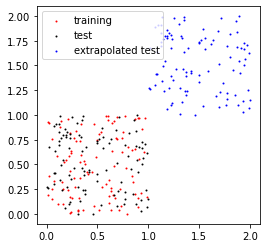

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
ax.scatter(x_train[:,0].detach(), x_train[:,1].detach(), color='red', label='training', s=1)
ax.scatter(x_val[:,0].detach(), x_val[:,1].detach(), color='black', label='test', s=1)
ax.scatter(x_val_ext[:,0].detach(), x_val_ext[:,1].detach(), color='blue', label='extrapolated test', s=1)
ax.legend()

In [20]:
def train(x_train, y_train, x_val, y_val, n_hidden=1000, n_epoch=1000, use_gradient=True):
    net = Net(2, n_hidden, 1)
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    train_loss = []
    val_loss = []
    for epoch in range(n_epoch):
        # Forward -> Backprob -> Update params
        ## Train
        optimizer.zero_grad()
        output = net(x_train)

        # compute gradients given loss
        loss = criterion(output, y_train.reshape(output.shape))
        train_loss.append(loss)
        val_loss.append(criterion(net(x_val), y_val))
        
        if use_gradient:
            _y_x = torch.autograd.grad(output, x_train, torch.ones([x_train.shape[0], 1]), create_graph=True)[0]
            dx1 = dfdx1(x_train[:,0], x_train[:,1])
            dx2 = dfdx2(x_train[:,0], x_train[:,1])
            loss += criterion(_y_x[:,0], dx1) + criterion(_y_x[:,1], dx2)
        loss.backward()
        optimizer.step()
        if (epoch)%10 == 0:
            print('Epoch: {:d}. Train loss: {:.2f}. Validation loss: {:.2f}'.format(epoch, train_loss[-1], val_loss[-1]))
    train_loss = [l.detach() for l in train_loss]
    val_loss = [l.detach() for l in val_loss]
    return net, output, train_loss, val_loss

In [21]:
nets = []
outputs = []
train_losses = []
val_losses = []
xs = []
ys = []
for _x, _y in [(x_val, y_val), (x_val_ext, y_val_ext)]:
    for t in [False, True]:
        net, output, train_loss, val_loss = train(x_train, y_train, _x, _y, n_epoch=100, use_gradient=t)
        nets.append(net)
        outputs.append(output)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        xs.append(_x)
        ys.append(_y)
        

Epoch: 0. Train loss: 4.56. Validation loss: 4.68
Epoch: 10. Train loss: 0.25. Validation loss: 1.36
Epoch: 20. Train loss: 0.02. Validation loss: 1.85
Epoch: 30. Train loss: 0.03. Validation loss: 1.89
Epoch: 40. Train loss: 0.01. Validation loss: 1.61
Epoch: 50. Train loss: 0.01. Validation loss: 1.62
Epoch: 60. Train loss: 0.00. Validation loss: 1.70
Epoch: 70. Train loss: 0.00. Validation loss: 1.69
Epoch: 80. Train loss: 0.00. Validation loss: 1.66
Epoch: 90. Train loss: 0.00. Validation loss: 1.67
Epoch: 0. Train loss: 11.03. Validation loss: 4.17
Epoch: 10. Train loss: 2.58. Validation loss: 1.05
Epoch: 20. Train loss: 1.37. Validation loss: 1.11
Epoch: 30. Train loss: 1.19. Validation loss: 1.09
Epoch: 40. Train loss: 1.09. Validation loss: 1.04
Epoch: 50. Train loss: 1.07. Validation loss: 1.03
Epoch: 60. Train loss: 1.06. Validation loss: 1.03
Epoch: 70. Train loss: 1.06. Validation loss: 1.02
Epoch: 80. Train loss: 1.06. Validation loss: 1.04
Epoch: 90. Train loss: 1.10. Val

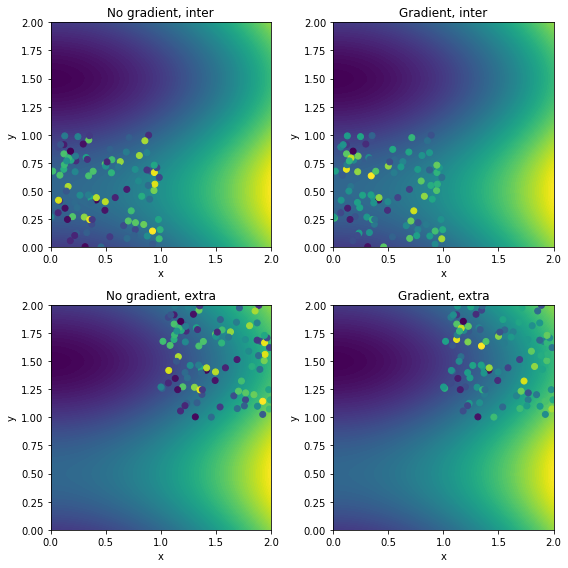

In [22]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
x1, x2 = np.meshgrid(np.linspace(0,2,50), np.linspace(0,2,50))
y1 = f(torch.tensor(x1), torch.tensor(x2)).detach()
labels = ['No gradient, inter', 'Gradient, inter', 'No gradient, extra', 'Gradient, extra']
for k, output in enumerate(outputs):
    
    axs[k//2, k%2].contourf(x1, x2, y1, 100)
    axs[k//2, k%2].scatter(xs[k][:,0].detach(), xs[k][:,1].detach(), c=output.detach())
    axs[k//2, k%2].set_xlabel('x')
    axs[k//2, k%2].set_ylabel('y')
    axs[k//2, k%2].set_title(labels[k])
fig.tight_layout()

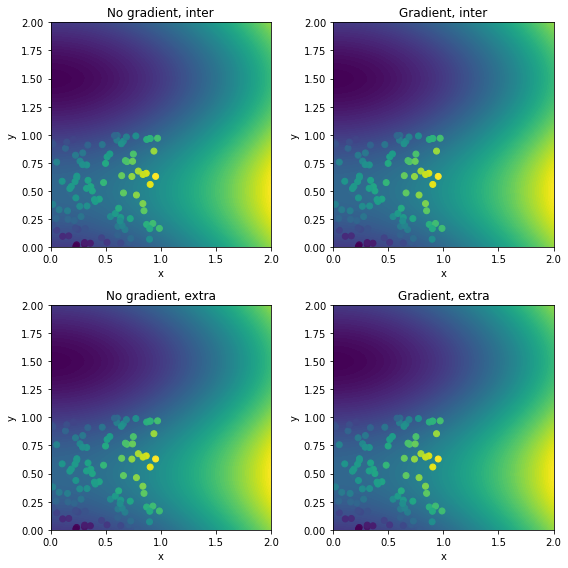

In [33]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
x1, x2 = np.meshgrid(np.linspace(0,2,50), np.linspace(0,2,50))
y1 = f(torch.tensor(x1), torch.tensor(x2)).detach()
labels = ['No gradient, inter', 'Gradient, inter', 'No gradient, extra', 'Gradient, extra']
for k, output in enumerate(outputs):
    
    axs[k//2, k%2].contourf(x1, x2, y1, 100)
    axs[k//2, k%2].scatter(x_train[:,0].detach(), x_train[:,1].detach(), c=net(x_train).detach())
    axs[k//2, k%2].set_xlabel('x')
    axs[k//2, k%2].set_ylabel('y')
    axs[k//2, k%2].set_title(labels[k])
fig.tight_layout()

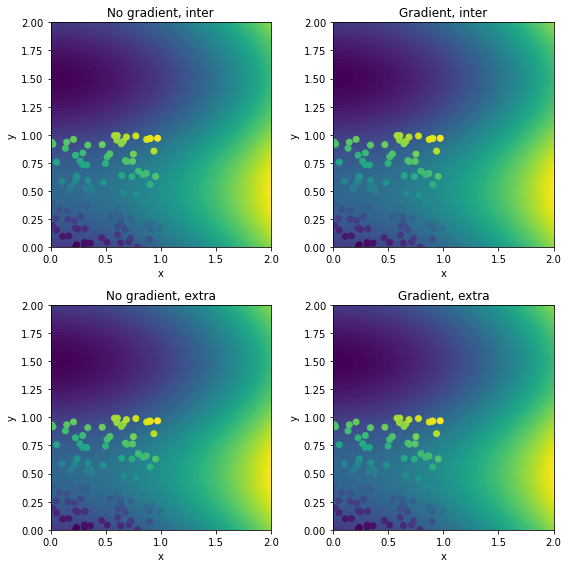

In [35]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
x1, x2 = np.meshgrid(np.linspace(0,2,50), np.linspace(0,2,50))
y1 = f(torch.tensor(x1), torch.tensor(x2)).detach()
labels = ['No gradient, inter', 'Gradient, inter', 'No gradient, extra', 'Gradient, extra']
for k, output in enumerate(outputs):
    
    axs[k//2, k%2].contourf(x1, x2, y1, 100)
    axs[k//2, k%2].scatter(x_train[:,0].detach(), x_train[:,1].detach(), c=y_train.detach())
    axs[k//2, k%2].set_xlabel('x')
    axs[k//2, k%2].set_ylabel('y')
    axs[k//2, k%2].set_title(labels[k])
fig.tight_layout()

## 1D attempts with gradient

In [131]:
def f(x):
    x = x.detach()
    return x**2 - x
def dfdx(x):
    x = x.detach()
    return 2*x -1


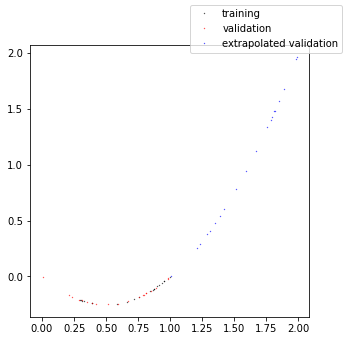

In [132]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
ax.plot(x_train.detach(), y_train.detach(), '.', markersize=0.6,color='black', label='training')
ax.plot(x_val.detach(), y_val.detach(), '.',markersize=0.6, color='red', label='validation')
ax.plot(x_val_ext.detach(), y_val_ext.detach(), '.', markersize=0.6, color='blue', label='extrapolated validation')
fig.legend()

In [315]:
def train1d(x_train, y_train, x_val, y_val, n_hidden=1000, n_epoch=1000, use_gradient=True):
    net = Net(1, n_hidden, 1)
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    train_loss = []
    val_loss = []
    for epoch in range(n_epoch):
        # Forward -> Backprob -> Update params
        ## Train
        optimizer.zero_grad()
        output = net(x_train)

        # compute loss
        loss = criterion(output, y_train.reshape(output.shape))
        train_loss.append(loss)
        val_loss.append(criterion(net(x_val), y_val))
        
        # Optionally use gradient of function
        if use_gradient:
            _y_x = torch.autograd.grad(output, x_train, torch.ones([x_train.shape[0], 1]), create_graph=True)[0]
            loss += criterion(_y_x[:,0], dfdx(x_train).reshape(_y_x[:,0].shape))
        
        # Backprop and update weights
        loss.backward()
        optimizer.step()
        
        #if (epoch)%300 == 0:
        #    print('Epoch: {:d}. Train loss: {:.2f}. Validation loss: {:.2f}'.format(epoch, train_loss[-1], val_loss[-1]))
    train_loss = [l.detach() for l in train_loss]
    val_loss = [l.detach() for l in val_loss]
    return net, train_loss, val_loss

Epoch: 0. Train loss: 0.02. Validation loss: 0.49
Epoch: 0. Train loss: 0.40. Validation loss: 0.47


Text(0.5, 1.0, 'With grad')

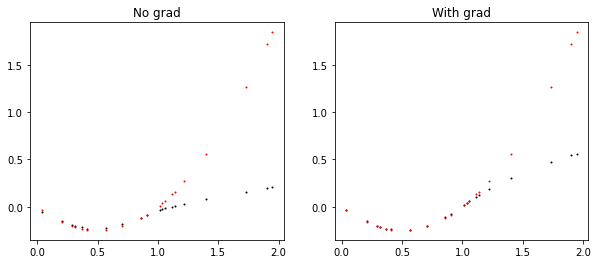

In [277]:
n = 20
x_train = torch.rand(n,requires_grad=True).reshape(-1, 1)
y_train = f(x_train)

x_val = torch.rand(n,requires_grad=True).reshape(-1, 1)*2
y_val = f(x_val)

net, train_loss, val_loss = train1d(x_train, y_train, x_val, y_val, n_hidden=100, n_epoch=50, use_gradient=False)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
ax[0].plot(x_val.detach(), net(x_val).detach(), '.', markersize=2, color='black')
ax[0].plot(x_val.detach(), y_val.detach(), '.', markersize=2, color='red')
#ax[0].plot(x_val_ext.detach(), net(x_val_ext).detach(), '.', markersize=2, color='black')
#ax[0].plot(x_val_ext.detach(), y_val_ext.detach(), '.', markersize=2, color='red')
ax[0].set_title('No grad')
net, train_loss, val_loss = train1d(x_train, y_train, x_val, y_val, n_hidden=100, n_epoch=50, use_gradient=True)
ax[1].plot(x_val.detach(), net(x_val).detach(), '.', markersize=2, color='black')
ax[1].plot(x_val.detach(), y_val.detach(), '.', markersize=2, color='red')
#ax[1].plot(x_val_ext.detach(), net(x_val_ext).detach(), '.', markersize=2, color='black')
#ax[1].plot(x_val_ext.detach(), y_val_ext.detach(), '.', markersize=2, color='red')
ax[1].set_title('With grad')

## How many training points?

In [348]:
ns = [5, 10, 20, 40, 80, 160, 320, 640, 1280]
loss = []
std = []
for n in ns:
    print(n)
    _loss = []
    for k in range(10):
        x_train = torch.rand(n,requires_grad=True).reshape(-1, 1)
        y_train = f(x_train)
        x_val = torch.rand(200,requires_grad=True).reshape(-1, 1)*2
        y_val = f(x_val)
        net, _, _ = train1d(x_train, y_train, x_val, y_val, n_hidden=100, n_epoch=200, use_gradient=False)
        output = net(x_val)
        _loss.append(torch.mean((output - y_val)**2).detach())
    loss.append(np.mean(_loss))
    std.append(np.std(_loss))

5
10
20
40
80
160
320
640
1280


In [351]:
ns = [5, 10, 20, 40, 80, 160, 320, 640, 1280]
loss_grad = []
std_grad = []
for n in ns:
    print(n)
    _loss = []
    for k in range(10):
        x_train = torch.rand(n,requires_grad=True).reshape(-1, 1)
        y_train = f(x_train)
        x_val = torch.rand(200,requires_grad=True).reshape(-1, 1)*2
        y_val = f(x_val)
        net, _, _ = train1d(x_train, y_train, x_val, y_val, n_hidden=100, n_epoch=200, use_gradient=True)
        output = net(x_val)
        _loss.append(torch.mean((output - y_val)**2).detach())
    loss_grad.append(np.mean(_loss))
    std_grad.append(np.std(_loss))

5
10
20
40
80
160
320
640
1280


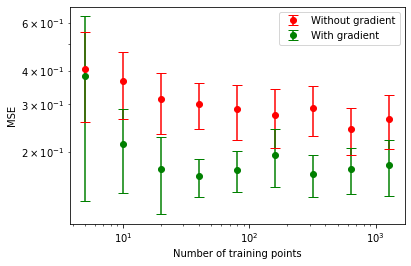

In [359]:
fig, ax = plt.subplots()
ax.errorbar(ns, loss, std, fmt='o', color='red', label='Without gradient', capsize=5)
ax.set_yscale('log')
ax.set_xscale('log')

ax.errorbar(ns, loss_grad, std_grad, fmt='o', color='green', label='With gradient', capsize=5)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('MSE')
ax.set_xlabel('Number of training points')
ax.legend()